# Intro

The following code provides you with surprisal values for the same data you used in Homework 2.  The surprisal values are based on the output of an RNN model.

We leave it up to you to perform the alignment between the model output and the reading times!

Feel free to skim through the code, it might be helpful for the semi-structured and open-ended tasks!

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment. It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [ ]:
%%bash
git clone https://github.com/scaperex/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


## Mount Google Drive

We'll save your corpus data, model checkpoints, and output to Google Drive for safekeeping. Follow the instructions in the output of this command to link your Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

## Upload corpus files for LM training

Here we upload the Penn Treebank corpus files  to the `rnn/data/ptb` folder.
Your files should be named:

- `ptb_tok_train.txt`
- `ptb_tok_dev.txt`

In [ ]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/scaperex/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/scaperex/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

# Recurrent neural network modeling

## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded
| epoch   1 |   200/ 1422 batches | lr 20.00 | ms/batch 13.43 | loss  6.84 | ppl   933.44
| epoch   1 |   400/ 1422 batches | lr 20.00 | ms/batch 12.42 | loss  6.06 | ppl   426.41
| epoch   1 |   600/ 1422 batches | lr 20.00 | ms/batch 12.46 | loss  5.91 | ppl   368.67
| epoch   1 |   800/ 1422 batches | lr 20.00 | ms/batch 12.50 | loss  5.84 | ppl   344.03
| epoch   1 |  1000/ 1422 batches | lr 20.00 | ms/batch 12.52 | loss  5.86 | ppl   349.66
| epoch   1 |  1200/ 1422 batches | lr 20.00 | ms/batch 14.42 | loss  5.79 | ppl   327.39
| epoch   1 |  1400/ 1422 batches | lr 20.00 | ms/batch 13.47 | loss  5.84 | ppl   343.46
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 18.72s | lr: 20.00000000 | valid ppl   274.27
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1422 batches | lr 20.00 | ms/batch 12.64 | loss  5.84 | ppl   342.74
| epoch   

## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:

!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file '$GDRIVE_DIR/ptb_vocab.txt' --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > '$GDRIVE_DIR/rnn_surprisals.tsv'


Libraries loaded
Using beamsize: 23757


Cool, let's check that the surprisal output looks right. (Compare with the ngram model surprisals from before.)

In [ ]:
import pandas as pd
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.055180,9.876316,0.000000
1,<unk>,0,1,5,5.601390,7.263554,2.612762
2,County,0,2,6,12.139956,6.840611,0.422943
3,<unk>,0,3,5,5.869784,5.000396,1.840215
4,near,0,4,4,12.134634,5.662076,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,6.210941,3.786661,4.894027
7230,a,363,16,1,2.533581,7.909486,0.000000
7231,leader,363,17,6,10.726473,11.061970,0.000000
7232,and,363,18,3,4.907414,5.541063,5.520907


## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model. 

In [ ]:
import pandas as pd

harmonized_ngram = pd.read_csv(f'{GDRIVE_DIR}/harmonized_ngram.csv')
reading_times = harmonized_ngram.iloc[:,2].values
surprisals_ngram = harmonized_ngram.iloc[:,3].values

In [ ]:
import string 
sprt = pd.read_csv('https://gist.githubusercontent.com/scaperex/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')


def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame) -> pd.DataFrame:
      # clean data
    surprs_data = surprs_data.copy()
    surprs_data = surprs_data[(surprs_data.word != '</s>')]
    surprs_data = surprs_data.reset_index()

    for i in range(0, len(surprs_data['word'])):
      word = surprs_data['word'][i]
      cleaned_word = word.translate(str.maketrans('', '', string.punctuation))
      surprs_data['word'][i]=cleaned_word
    surprs_data = surprs_data[(surprs_data.word != '')]
    surprs_data = surprs_data[(surprs_data.word != 'H')]
    surprs_data = surprs_data.reset_index()
    
    rt_data = rt_data.sort_values(by=(['text_id','text_pos']))
    rt_data = pd.DataFrame(rt_data.groupby(['text_id','text_pos','word'])['time'].mean()).reset_index()
    for i in range(0, len(rt_data['word'])):
      word = rt_data['word'][i]
      cleaned_word = word.translate(str.maketrans('', '', string.punctuation))
      if word != cleaned_word:
        rt_data['word'][i] = cleaned_word

    # join data
    harmonized_data = rt_data.merge(surprs_data, left_index=True, right_index=True, how='inner')
    harmonized_data = harmonized_data[(harmonized_data.word_y != 'unk')]
    harmonized_data = harmonized_data[['word_x','time', 'surp']]
    return harmonized_data

print(sprt)
harmonized_rnn = harmonize(sprt, rnn_surprisals)
print(sprt)
surprisals_rnn = harmonized_rnn.iloc[:,2].values

            word   code subject  text_id  text_pos  word_in_exp    time
2286          In  17000    s001        0         0         2285  399.90
109460        In  17000    s028        0         0         2503  290.32
50709         In  17000    s014        0         0         1394  501.59
80486         In  17000    s021        0         0         2525  210.93
35626         In  17000    s010        0         0          579  862.35
...          ...    ...     ...      ...       ...          ...     ...
79391   captain.  35763    s021       12       763         1430  425.18
116505  captain.  35763    s030       12       763         1489  383.32
26975   captain.  35763    s007       12       763         3426  506.40
15206   captain.  35763    s004       12       763         3528  669.29
83386   captain.  35763    s022       12       763          763  304.40

[136907 rows x 7 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


            word   code subject  text_id  text_pos  word_in_exp    time
2286          In  17000    s001        0         0         2285  399.90
109460        In  17000    s028        0         0         2503  290.32
50709         In  17000    s014        0         0         1394  501.59
80486         In  17000    s021        0         0         2525  210.93
35626         In  17000    s010        0         0          579  862.35
...          ...    ...     ...      ...       ...          ...     ...
79391   captain.  35763    s021       12       763         1430  425.18
116505  captain.  35763    s030       12       763         1489  383.32
26975   captain.  35763    s007       12       763         3426  506.40
15206   captain.  35763    s004       12       763         3528  669.29
83386   captain.  35763    s022       12       763          763  304.40

[136907 rows x 7 columns]


# Next Steps

For the next steps, follow the PDF project instructions.

Good luck!

## Structured Tasks: Compare n-gram and RNN models

# #1
Which model has surprisal estimates which correlate better with human reading times?

In [ ]:
import numpy as np
import statsmodels.api as sm

print(f'covariance of reading time and ngram: {np.corrcoef(reading_times, surprisals_ngram)[0, 1]}')
print(f'covariance of reading time and rnn: {np.corrcoef(reading_times, surprisals_rnn)[0, 1]}')

x = surprisals_rnn
y = reading_times
x = sm.add_constant(x)
lin_model = sm.OLS(y, x)
lin_model = lin_model.fit()
print(lin_model.summary())

x = surprisals_ngram
y = reading_times
x = sm.add_constant(x)
lin_model = sm.OLS(y, x)
lin_model = lin_model.fit()
print(lin_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


covariance of reading time and ngram: 0.05034859347280153
covariance of reading time and rnn: 0.06316038392320165
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     22.01
Date:                Sun, 03 Jul 2022   Prob (F-statistic):           2.77e-06
Time:                        19:22:52   Log-Likelihood:                -30415.
No. Observations:                5498   AIC:                         6.083e+04
Df Residuals:                    5496   BIC:                         6.085e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

the rnn surprisals correlate better with the human reading times.

# #2
Plot the relationship between the n-gram model’s surprisal estimate for a word and
the RNN’s estimate. Each point in the graph should correspond to a single token from
the harmonized data. Describe what you see in this graph. Are the models generally
well matched? On what parts of the surprisal spectrum do they disagree?

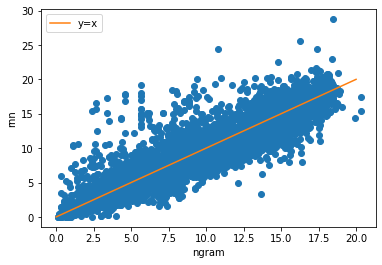

In [ ]:
import matplotlib.pyplot as plt

plt.plot(surprisals_ngram, surprisals_rnn, 'o')
plt.plot(np.linspace(0.0, 20.0, num=100), np.linspace(0.0, 20.0, num=100), label='y=x')
plt.xlabel('ngram')
plt.ylabel('rnn')
plt.legend()
plt.show()

Generaly speaking, the models are well matched.<br>
The models seem to sometimes disagree on the [0, 10] interval of ngram surprisals.


# #3
Pick specific interesting points from this graph (for example, points where the two
models have very different surprisal estimates) and report the sentences containing the
corresponding tokens. Why do you think the models should disagree?


In [ ]:
import numpy as np

w1 = "enemies"
s1 = "I state categorically that we shall under no circumstances resort to the use of such wepons unless they are first used by our enemies"

w2 = "Hoawup"
s2 = "Ben prime extended his stride until he could lay his goad across the noses of the Hoawup"

w3 = "I"
s3 = "In and out of the established and increasingly cold weather soon raised with the water cooled engine of their World War I tanks"

# #4
Examine spillover in both models: look at the relationship between word probability
and the next word’s reading time (a “spillover” effect). Is the effect similar as on the
current word? Bigger? Smaller? Different shape? Are the spillover effects different
across the two models?

In [ ]:
mean={}
count={}
for i in range(harmonized_ngram.shape[0]):
  s = harmonized_ngram['word'][i]
  if s not in mean.keys():
    mean[s] = reading_times[i]
    count[s] = 1
  else:
    mean[s] += reading_times[i]
    count[s] += 1
for s in mean.keys():
  mean[s] /= count[s]

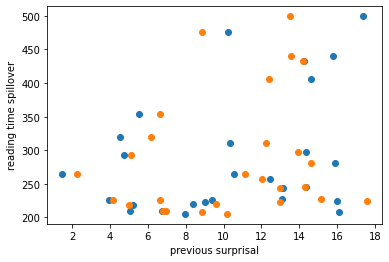

In [ ]:
x1=[]
x2=[]
y=[]
for i in range(1, harmonized_ngram.shape[0]):
  a = reading_times[i] - mean[harmonized_ngram['word'][i]]
  if a>200:
    x1.append(surprisals_rnn[i-1])
    x2.append(surprisals_ngram[i-1])
    y.append(a)
plt.plot(x1, y, 'o')
plt.plot(x2, y, 'o')
plt.xlabel('previous surprisal')
plt.ylabel('reading time spillover')
plt.show()


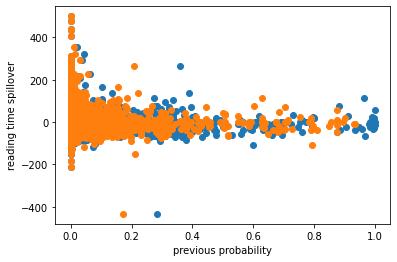

In [ ]:
x1=[]
x2=[]
y=[]
for i in range(1, harmonized_ngram.shape[0]):
  x1.append(1/2**surprisals_rnn[i-1])
  x2.append(1/2**surprisals_ngram[i-1])
  y.append(reading_times[i] - mean[harmonized_ngram['word'][i]])
plt.plot(x1, y, 'o')
plt.plot(x2, y, 'o')
plt.xlabel('previous probability')
plt.ylabel('reading time spillover')
plt.show()

# Semi-structured Task #1
Fit and plot the RT surprisal curve using a General Additive Model (GAM). The
model should include control variables for log-frequency and word length. Examine
both current word and spillover effects.

In [ ]:
!pip install pygam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 30.0 MB/s 


In [ ]:
import math
df = harmonized_ngram.copy()
words = harmonized_ngram['word']
log_freq_dict = {}
for word in words:
  if word in log_freq_dict:
    log_freq_dict[word] += 1
  else:
    log_freq_dict[word] = 1
s0=[]
for word in log_freq_dict:
  log_freq_dict[word] = math.log(log_freq_dict[word])
for word in words:
  s0.append(log_freq_dict[word])

sur = harmonized_rnn['surp'].reset_index()
s1=[]
s1.append(0)
for i in range(1, len(sur['surp'])):
  s1.append(sur['surp'][i-1])
df['log_frq'] = s0
df['word_len'] = df['word'].apply(lambda x: len(x))
df['surprisal_rnn'] = sur['surp']
df['prev_surp']=s1
df

,Unnamed: 0,word,time,surprisal,log_frq,word_len,surprisal_rnn,prev_surp
0,0,In,380.275294,4.57937,2.564949,2,5.055180,0.000000
1,2,County,296.042941,12.65410,0.000000,6,12.139956,5.055180
2,4,near,403.553529,12.22380,1.609438,4,12.134634,12.139956
3,5,the,306.075882,1.98095,5.880533,3,1.783278,12.134634
4,6,River,289.048235,15.70900,1.609438,5,15.958303,1.783278
...,...,...,...,...,...,...,...,...
5493,7182,failed,292.772500,8.25341,0.000000,6,9.281180,4.865627
5494,7183,as,284.470833,9.42416,4.043051,2,6.210941,9.281180
5495,7184,a,282.622083,3.23962,4.875197,1,2.533581,6.210941
5496,7185,leader,279.445417,12.81650,0.693147,6,10.726473,2.533581


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      26.981
Link Function:                     IdentityLink Log Likelihood:                                -40037.1623
Number of Samples:                         4398 AIC:                                            80130.2865
                                                AICc:                                           80130.6578
                                                GCV:                                              3624.653
                                                Scale:                                           3584.6491
                                                Pseudo R-Squared:                                   0.0714
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



<Figure size 432x288 with 0 Axes>

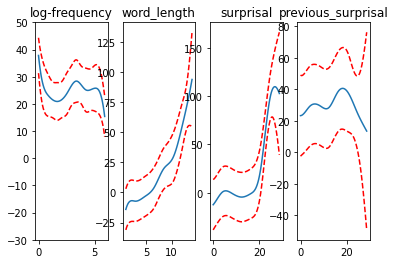

In [ ]:
from pygam import LinearGAM, s, f
import numpy as np
import matplotlib.pyplot as plt


X = df.to_numpy()[:,4:8]
y = df.time.values

"""train_size = int(X.shape[0] * 0.8)
test_size = X.shape[0] - train_size
train_indices = np.random.randint(X.shape[0], size=train_size)
test_indices = np.random.randint(X.shape[0], size=test_size)

train_y = y[train_indices]
test_y = y[test_indices]
train_x = X[train_indices, :]
test_x = X[test_indices, :]"""

## model
gam = LinearGAM(s(0, n_splines=10) + s(1, n_splines=10) + s(2, n_splines=10) + s(3, n_splines=10)).fit(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,4);

titles = ['log-frequency', 'word_length', 'surprisal', 'previous_surprisal']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,50)
    ax.set_title(titles[i]);
print(gam.summary())

# Semi-structured Task #3
Train n-gram and RNN models on a larger dataset, such as Wikitext-2, Wikitext-103,
and/or a still larger dataset (note that training larger models on Colab might require
some careful checkpointing work), and see what happens to the relationship with RTs.

In [ ]:
%%bash
git clone https://github.com/scaperex/neural-complexity.git rnn
mkdir -p rnn/data/ptb

fatal: destination path 'rnn' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

In [ ]:
!cp rnn/data/wikitext-2/* "$GDRIVE_DIR/corpus_data/"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model_wiki.pt" \
    --epochs 64 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab_wiki.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname train.txt --validfname valid.txt

Libraries loaded
Traceback (most recent call last):
  File "main.py", line 219, in <module>
    testfname=args.testfname)
  File "/content/rnn/data.py", line 46, in __init__
    self.train = self.tokenize(os.path.join(path, trainfname))
  File "/content/rnn/data.py", line 109, in tokenize
    assert os.path.exists(path), "Bad path: %s" % path
AssertionError: Bad path: /content/gdrive/My Drive/096222_project_surprisals_and_rts/corpus_data/train.txt


In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model_wiki.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file '$GDRIVE_DIR/ptb_vocab_wiki.txt' --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > '$GDRIVE_DIR/rnn_surprisals_wiki.tsv'

Libraries loaded
Using beamsize: 33278


In [ ]:
import pandas as pd
rnn_surprisals_wiki = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals_wiki.tsv',sep=' ')
rnn_surprisals_wiki

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,7.657288,10.470191,0.000000
1,<unk>,0,1,5,5.165999,9.574603,0.895588
2,County,0,2,6,10.197677,8.719383,0.855220
3,<unk>,0,3,5,6.549869,6.384947,2.334436
4,near,0,4,4,10.282216,7.603141,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,6.909204,3.014119,5.042266
7230,a,363,16,1,2.904558,8.334778,0.000000
7231,leader,363,17,6,12.397602,11.548065,0.000000
7232,and,363,18,3,5.803991,4.319426,7.228639


In [ ]:
harmonized_rnn_wiki = harmonize(sprt, rnn_surprisals_wiki)
harmonized_rnn_wiki

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,word_x,time,surp
0,In,380.275294,7.657288
2,County,296.042941,10.197677
4,near,403.553529,10.282216
5,the,306.075882,1.540309
6,River,289.048235,11.940998
...,...,...,...
7182,failed,292.772500,9.237367
7183,as,284.470833,6.909204
7184,a,282.622083,2.904558
7185,leader,279.445417,12.397602


In [ ]:
harmonized_rnn.columns = ['word_rnn', 'time_rnn', 'surp_rnn']
harmonized_rnn_wiki.columns = ['word_wiki', 'time_wiki', 'surp_wiki']

harmonized_rnn_wiki = pd.merge(harmonized_rnn_wiki, harmonized_rnn, left_index=True, right_index=True)
reading_times_new = harmonized_rnn_wiki['time_wiki'].values
surprisals_rnn_wiki = harmonized_rnn_wiki['surp_wiki'].values
surprisals_rnn_new = harmonized_rnn_wiki['surp_rnn'].values
harmonized_rnn_wiki

,word_wiki,time_wiki,surp_wiki,word_rnn,time_rnn,surp_rnn
0,In,380.275294,7.657288,In,380.275294,5.055180
2,County,296.042941,10.197677,County,296.042941,12.139956
4,near,403.553529,10.282216,near,403.553529,12.134634
5,the,306.075882,1.540309,the,306.075882,1.783278
6,River,289.048235,11.940998,River,289.048235,15.958303
...,...,...,...,...,...,...
7182,failed,292.772500,9.237367,failed,292.772500,9.281180
7183,as,284.470833,6.909204,as,284.470833,6.210941
7184,a,282.622083,2.904558,a,282.622083,2.533581
7185,leader,279.445417,12.397602,leader,279.445417,10.726473


In [ ]:
import numpy as np

print(f'covariance of reading time and rnn: {np.corrcoef(reading_times_new, surprisals_rnn_new)[0, 1]}')
print(f'covariance of reading time and rnn_wiki: {np.corrcoef(reading_times_new, surprisals_rnn_wiki)[0, 1]}')

x = surprisals_rnn_new
y = reading_times_new
x = sm.add_constant(x)
lin_model = sm.OLS(y, x)
lin_model = lin_model.fit()
print(lin_model.summary())

x = surprisals_rnn_wiki
y = reading_times_new
x = sm.add_constant(x)
lin_model = sm.OLS(y, x)
lin_model = lin_model.fit()
print(lin_model.summary())


covariance of reading time and rnn: 0.06189967933808274
covariance of reading time and rnn_wiki: 0.06064350392217411
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     20.77
Date:                Sun, 03 Jul 2022   Prob (F-statistic):           5.28e-06
Time:                        19:26:40   Log-Likelihood:                -29896.
No. Observations:                5403   AIC:                         5.980e+04
Df Residuals:                    5401   BIC:                         5.981e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

# Open-ended Task
Devise and carry out an additional substantial analysis not listed above.

In [ ]:
%%bash
git clone https://github.com/scaperex/neural-complexity.git rnn
cd rnn
git checkout tags/v1.1.0

fatal: destination path 'rnn' already exists and is not an empty directory.
HEAD is now at 4b85c72 Merge pull request #3 from forrestdavis/master


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/hebrew_model.pt"

In [ ]:
#!wget -qO GDRIVE_DIR/hebrew_model.pt https://dl.fbaipublicfiles.com/colorless-green-rnns/best-models/Hebrew/hidden650_batch64_dropout0.1_lr20.0.pt

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install inltk
!pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
a1 = "אני אוהב לאכול חתולים"
a2 = "אני אוהב לאכול גלידה"
a3 = "כשאף אחד לא באינקווזיציה"
a4 = "כשאף אחד לא שומע"
a5 = "אז הם ארזו חצי ארגז"
a6 = "אז הם ארזו חצי מיקרופון"
a7 = "עלו על אוטו למרכז"
a8 = "עלו על אוטו למטוס"
b1 = "אני אהבתי אוכל ירקות"
b2 = "אני עכשיו אוכל ירקות"
b3 = "הם לא כל כך יפים, אני יודע"
b4 = "הם לא כל כך יפים, היא יודע"
b5 = "ואין שום הרבה טעם לרוק"
b6 = "ואין שום טעם לרוק"
b7 = "אז רק תבואו למסיבה"
b8 = "אז למה תבואו למסיבה"

sent1 = "אני אוהב פיצה"
sent2 = "הילדים אכלו פיצה"

!cd rnn && python main.py --model_file "$checkpoint_to_use" \
    --vocab_file '$GDRIVE_DIR/hebrew_vocab_test_2.txt' --data_dir '$GDRIVE_DIR' \
    --testfname 'hebrew_text.txt' --test --words --nopp > '$GDRIVE_DIR/hebrew_surprisals.tsv'

Libraries loaded
Using beamsize: 50001


In [ ]:
import pandas as pd
hebrew_surprisals = pd.read_csv(f'{GDRIVE_DIR}/hebrew_surprisals.tsv',sep=' ')
hebrew_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,אני,0,0,3,18.255554,4.973571,0.000000
1,אוהב,0,1,4,23.498884,4.725500,0.248071
2,פיצה,0,2,4,24.097258,7.035322,0.000000


# **Open Task 2**

In [60]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file '$GDRIVE_DIR/ptb_vocab.txt' --data_dir './data' \
    --testfname 'othello.txt' --test --words --nopp > '$GDRIVE_DIR/othello_surprisals.tsv'

othello_surprisals = pd.read_csv(f'{GDRIVE_DIR}/othello_surprisals.tsv',sep=' ')


!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file '$GDRIVE_DIR/ptb_vocab.txt' --data_dir './data' \
    --testfname 'blade_squadron.txt' --test --words --nopp > '$GDRIVE_DIR/blade_surprisals.tsv'

blade_surprisals = pd.read_csv(f'{GDRIVE_DIR}/blade_surprisals.tsv',sep=' ')


harmonized_othello = harmonize(sprt, othello_surprisals).reset_index()
harmonized_blade = harmonize(sprt, blade_surprisals).reset_index()

Libraries loaded
Traceback (most recent call last):
  File "main.py", line 608, in <module>
    model = torch.load(f).to(device)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 426, in load
    return _load(f, map_location, pickle_module, **pickle_load_args)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 613, in _load
    result = unpickler.load()
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 576, in persistent_load
    deserialized_objects[root_key] = restore_location(obj, location)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 155, in default_restore_location
    result = fn(storage, location)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 131, in _cuda_deserialize
    device = validate_cuda_device(location)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 115, in validate_cuda_device
    raise RuntimeError(

EmptyDataError: ignored

In [ ]:
mean1={}
count1={}
avg1=0
avg12=0
avg11=0
for i in range(harmonized_blade.shape[0]):
  avg1+=1
  avg12+=harmonized_blade['surp'][i]*harmonized_blade['surp'][i]
  avg11+=harmonized_blade['surp'][i]
  s = harmonized_blade['word_y'][i]
  if s not in mean1.keys():
    mean1[s] = harmonized_blade['surp'][i]
    count1[s] = 1
  else:
    mean1[s] += harmonized_blade['surp'][i]
    count1[s] += 1
for s in mean1.keys():
  mean1[s] /= count1[s]

mean2={}
count2={}
avg2=0
avg22=0
avg21=0
for i in range(harmonized_othello.shape[0]):
  avg2+=1
  avg22+=harmonized_othello['surp'][i]*harmonized_othello['surp'][i]
  avg21+=harmonized_othello['surp'][i]
  s = harmonized_othello['word_y'][i]
  if s not in mean2.keys():
    mean2[s] = harmonized_othello['surp'][i]
    count2[s] = 1
  else:
    mean2[s] += harmonized_othello['surp'][i]
    count2[s] += 1
for s in mean2.keys():
  mean2[s] /= count2[s]

avg12=avg12/avg1
avg22=avg22/avg2
avg1=avg11/avg1
avg2=avg21/avg2
print(avg1)
print(avg2)
print(avg12-avg1*avg1)
print(avg22-avg2*avg2)

In [ ]:
import matplotlib.pyplot as plt
x1=[]
x2=[]
y=[]
far=[]
a=0
b=0
for i in range(harmonized_othello.shape[0]):
  y.append(i)
  a+=harmonized_blade['surp'][i]
  b+=harmonized_othello['surp'][i]
  x1.append(a)
  x2.append(b)
for i in mean2.keys():
  if i in mean1.keys():
    if (mean1[i]-mean2[i]>5) or (mean2[i]-mean1[i]>5):
      far.append(i)
plt.plot(y, x1, 'o')
plt.plot(y, x2, 'o')
plt.xlabel('Cumilative Surprisal')
plt.ylabel('word in text')
plt.show()
print(far)

In [ ]:
import math
df = harmonized_othello.copy()
words = harmonized_othello['word_y']
log_freq_dict = {}
for word in words:
  if word in log_freq_dict:
    log_freq_dict[word] += 1
  else:
    log_freq_dict[word] = 1
s0=[]
for word in log_freq_dict:
  log_freq_dict[word] = math.log(log_freq_dict[word])
for word in words:
  s0.append(log_freq_dict[word])

df['log_frq'] = s0
sur = harmonized_rnn['surp'].reset_index()
df['word_len'] = df['word_y'].apply(lambda x: len(x))
df['surprisal_rnn'] = sur['surp']

In [ ]:
from pygam import LinearGAM, s, f
import numpy as np


X = df.to_numpy()[:,3:6]
y = df.time.values

train_size = int(X.shape[0] * 0.8)
test_size = X.shape[0] - train_size
train_indices = np.random.randint(X.shape[0], size=train_size)
test_indices = np.random.randint(X.shape[0], size=test_size)

train_y = y[train_indices]
test_y = y[test_indices]
train_x = X[train_indices, :]
test_x = X[test_indices, :]

## model
gam = LinearGAM(s(0, n_splines=10) + s(1, n_splines=10) + s(2, n_splines=10)).fit(train_x, train_y)
#gam.gridsearch(X, y)

df = harmonized_blade.copy()
words = harmonized_blade['word_y']
log_freq_dict = {}
for word in words:
  if word in log_freq_dict:
    log_freq_dict[word] += 1
  else:
    log_freq_dict[word] = 1
s0=[]
for word in log_freq_dict:
  log_freq_dict[word] = math.log(log_freq_dict[word])
for word in words:
  s0.append(log_freq_dict[word])

df['log_frq'] = s0
sur = harmonized_rnn['surp'].reset_index()
df['word_len'] = df['word_y'].apply(lambda x: len(x))
df['surprisal_rnn'] = sur['surp']


X2 = df.to_numpy()[:,3:6]
y2 = df.time.values

train_size2 = int(X2.shape[0] * 0.8)
test_size2 = X2.shape[0] - train_size2
train_indices2 = np.random.randint(X.shape[0], size=train_size2)
test_indices2 = np.random.randint(X.shape[0], size=test_size2)

train_y2 = y2[train_indices2]
test_y2 = y2[test_indices2]
train_x2 = X2[train_indices2, :]
test_x2 = X2[test_indices2, :]

## model
gam2 = LinearGAM(s(0, n_splines=10) + s(1, n_splines=10) + s(2, n_splines=10)).fit(train_x2, train_y2)
#gam.gridsearch(X, y)



## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['surprisal', 'log-frequency', 'word_length']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    XX2 = gam2.generate_X_grid(term=i)
    ax.plot(XX2[:, i], gam2.partial_dependence(term=i, X=XX2))
    ax.plot(XX2[:, i], gam2.partial_dependence(term=i, X=XX2, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);
print(gam.summary())

#Turn to pdf

In [61]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf

colab_pdf(file_name='Project_Language.ipynb', notebookpath="/content/drive/MyDrive/Colab Notebooks/")

--2022-07-03 19:51:49--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-07-03 19:51:50 (34.1 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

Mounted at /content/drive/




Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Project_Language.ipynb to pdf
[NbConvertApp] Support files will be in Project_Language_files/
[NbConvertApp] Making directory ./Project_Language_files
[NbConvertApp] Making directory ./Project_Language_files
[NbConvertApp] Making directory ./Project_Language_files
[NbConvertApp]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'